# Overview

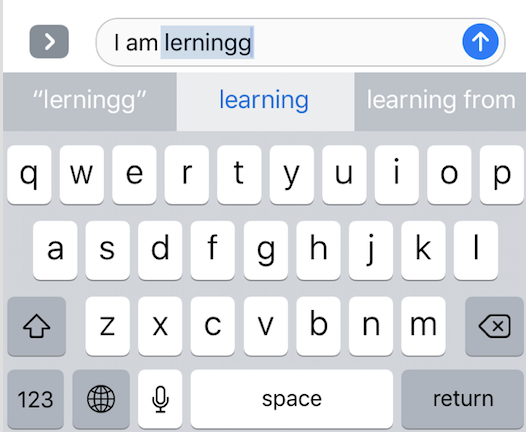

In [4]:
from IPython.display import Image
Image(filename='/Users/amanprasad/Documents/Courses_IIT_Fall_2019/NLP/Auto_Correction/auto-correct.png')

In this Project, we will implement models that correct words that are 1 and 2 edit distances away. 
- We say two words are n edit distance away from each other when we need n edits to change one word into another. 

An edit could consist of one of the following options: 

- Delete (remove a letter): ‘hat’ => ‘at, ha, ht’
- Switch (swap 2 adjacent letters): ‘eta’ => ‘eat, tea,...’
- Replace (change 1 letter to another): ‘jat’ => ‘hat, rat, cat, mat, ...’
- Insert (add a letter): ‘te’ => ‘the, ten, ate, ...’

We will be using the four methods above to implement an Auto-correct. 
- To do so, you will need to compute probabilities that a certain word is correct given an input. 

The goal of our spell check model is to compute the following probability:

$$P(c|w) = \frac{P(w|c)\times P(c)}{P(w)} \tag{Eqn-1}$$

The equation above is [Bayes Rule](https://en.wikipedia.org/wiki/Bayes%27_theorem). 
- Equation 1 says that the probability of a word being correct $P(c|w) $is equal to the probability of having a certain word $w$, given that it is correct $P(w|c)$, multiplied by the probability of being correct in general $P(C)$ divided by the probability of that word $w$ appearing $P(w)$ in general.
- To compute equation 1, we will first import a data set and then create all the probabilities that we need using that data set. 

# Data Preprocessing 

In [1]:
import re
from collections import Counter
import numpy as np
import pandas as pd

In [2]:
def process_data(file_name):
    """
    Input: 
        A file_name which is found in your current directory. You just have to read it in. 
    Output: 
        words: a list containing all the words in the corpus (text file you read) in lower case. 
    """
    words = [] # return this variable correctly
    
    with open(file_name) as f:
        file_name_data = f.read()
    file_name_data=file_name_data.lower()
    words = re.findall('\w+',file_name_data)

    return words

In [3]:
word_l = process_data('shakespeare.txt')
vocab = set(word_l)  # this will be your new vocabulary
print(f"The first ten words in the text are: \n{word_l[0:10]}")
print(f"There are {len(vocab)} unique words in the vocabulary.")

The first ten words in the text are: 
['o', 'for', 'a', 'muse', 'of', 'fire', 'that', 'would', 'ascend', 'the']
There are 6116 unique words in the vocabulary.


Implementing a `get_count` function that returns a dictionary
- The dictionary's keys are words
- The value for each word is the number of times that word appears in the corpus. 

In [5]:
def get_count(word_l):
    '''
    Input:
        word_l: a set of words representing the corpus. 
    Output:
        word_count_dict: The wordcount dictionary where key is the word and value is its frequency.
    '''
    
    word_count_dict = {}  # fill this with word counts
    '''
    #One way
    for i in word_l:
        word_count_dict[i] = word_count_dict.get(i,0)+1
    '''
    #other way
    word_count_dict = Counter(word_l)

    return word_count_dict

In [6]:
word_count_dict = get_count(word_l)
print(f"There are {len(word_count_dict)} key values pairs")
print(f"The count for the word 'thee' is {word_count_dict.get('thee',0)}")

There are 6116 key values pairs
The count for the word 'thee' is 240


Now given the dictionary of word counts, we will compute the probability that each word will appear if randomly selected from the corpus of words.

$$P(w_i) = \frac{C(w_i)}{M} \tag{Eqn-2}$$
where 

$C(w_i)$ is the total number of times $w_i$ appears in the corpus.

$M$ is the total number of words in the corpus.

In [7]:
def get_probs(word_count_dict):
    '''
    Input:
        word_count_dict: The wordcount dictionary where key is the word and value is its frequency.
    Output:
        probs: A dictionary where keys are the words and the values are the probability that a word will occur. 
    '''
    probs = {} 
    
    M=sum(word_count_dict.values())
    for key in word_count_dict:
        probs[key]=word_count_dict[key]/M
    
    return probs

In [8]:
probs = get_probs(word_count_dict)
print(f"Length of probs is {len(probs)}")
print(f"P('thee') is {probs['thee']:.4f}")

Length of probs is 6116
P('thee') is 0.0045


# String Manipulations

Now, that we have computed $P(w_i)$ for all the words in the corpus, we will write a few functions to manipulate strings so that you can edit the erroneous strings and return the right spellings of the words.

* `delete_letter`: given a word, it returns all the possible strings that have **one character removed**. 
* `switch_letter`: given a word, it returns all the possible strings that have **two adjacent letters switched**.
* `replace_letter`: given a word, it returns all the possible strings that have **one character replaced by another different letter**.
* `insert_letter`: given a word, it returns all the possible strings that have an **additional character inserted**. 


In [9]:
def delete_letter(word, verbose=False):
    '''
    Input:
        word: the string/word for which you will generate all possible words 
                in the vocabulary which have 1 missing character
    Output:
        delete_l: a list of all possible strings obtained by deleting 1 character from word
    '''
    
    delete_l = []
    split_l = []
    
    split_l=[(word[:i],word[i:]) for i in range(len(word))]
    delete_l=[L + R[1:] for L,R in split_l if R]

    if verbose: print(f"input word {word}, \nsplit_l = {split_l}, \ndelete_l = {delete_l}")

    return delete_l

In [10]:
delete_word_l = delete_letter(word="cans", verbose=True)

input word cans, 
split_l = [('', 'cans'), ('c', 'ans'), ('ca', 'ns'), ('can', 's')], 
delete_l = ['ans', 'cns', 'cas', 'can']


In [11]:
def switch_letter(word, verbose=False):
    '''
    Input:
        word: input string
     Output:
        switches: a list of all possible strings with one adjacent charater switched
    ''' 
    
    switch_l = []
    split_l = []
    
    l=0
    r=0
    
    split_l=[(word[:i],word[i:]) for i in range(len(word))]
    
    for L, R in split_l:
        if ((len(L)!=0) & (len(R)!=0)):
            l=len(str(L))
            r=len(str(R))
            switch_l.append(L[:l-1] + R[0] + L[-1] + R[1:])
            
    if verbose: print(f"Input word = {word} \nsplit_l = {split_l} \nswitch_l = {switch_l}") 

    return switch_l

In [12]:
switch_word_l = switch_letter(word="eta",verbose=True)

Input word = eta 
split_l = [('', 'eta'), ('e', 'ta'), ('et', 'a')] 
switch_l = ['tea', 'eat']


In [13]:
def replace_letter(word, verbose=False):
    '''
    Input:
        word: the input string/word 
    Output:
        replaces: a list of all possible strings where we replaced one letter from the original word. 
    ''' 
    
    letters = 'abcdefghijklmnopqrstuvwxyz'
    replace_l = []
    split_l = []
    
    split_l=[(word[:i],word[i:]) for i in range(len(word))]
    
    for L,R in split_l:
        for j in range(len(letters)):
            replace_l.append(L + letters[j] + R[1:])
            replace_set = (set(replace_l))
    
    # turn the set back into a list and sort it, for easier viewing
    replace_l = sorted(list(replace_set))
    replace_l.remove(word)
    
    if verbose: print(f"Input word = {word} \nsplit_l = {split_l} \nreplace_l {replace_l}")   
    
    return replace_l

In [14]:
replace_l = replace_letter(word='can',verbose=True)

Input word = can 
split_l = [('', 'can'), ('c', 'an'), ('ca', 'n')] 
replace_l ['aan', 'ban', 'caa', 'cab', 'cac', 'cad', 'cae', 'caf', 'cag', 'cah', 'cai', 'caj', 'cak', 'cal', 'cam', 'cao', 'cap', 'caq', 'car', 'cas', 'cat', 'cau', 'cav', 'caw', 'cax', 'cay', 'caz', 'cbn', 'ccn', 'cdn', 'cen', 'cfn', 'cgn', 'chn', 'cin', 'cjn', 'ckn', 'cln', 'cmn', 'cnn', 'con', 'cpn', 'cqn', 'crn', 'csn', 'ctn', 'cun', 'cvn', 'cwn', 'cxn', 'cyn', 'czn', 'dan', 'ean', 'fan', 'gan', 'han', 'ian', 'jan', 'kan', 'lan', 'man', 'nan', 'oan', 'pan', 'qan', 'ran', 'san', 'tan', 'uan', 'van', 'wan', 'xan', 'yan', 'zan']


In [15]:
def insert_letter(word, verbose=False):
    '''
    Input:
        word: the input string/word 
    Output:
        inserts: a set of all possible strings with one new letter inserted at every offset
    ''' 
    letters = 'abcdefghijklmnopqrstuvwxyz'
    insert_l = []
    split_l = []
    
    split_l = [(word[:i],word[i:]) for i in range(len(word)+1)]
    
    for L,R in split_l:
        for j in range(len(letters)):
            insert_l.append(L + letters[j] + R)
    insert_ll=set(insert_l)
    
    #insert_l = sorted(list(insert_ll))
    
    if verbose: print(f"Input word {word} \nsplit_l = {split_l} \ninsert_l = {insert_l}")
    
    return insert_l

In [16]:
insert_l = insert_letter('at', True)
print(f"Number of strings output by insert_letter('at') is {len(insert_l)}")

Input word at 
split_l = [('', 'at'), ('a', 't'), ('at', '')] 
insert_l = ['aat', 'bat', 'cat', 'dat', 'eat', 'fat', 'gat', 'hat', 'iat', 'jat', 'kat', 'lat', 'mat', 'nat', 'oat', 'pat', 'qat', 'rat', 'sat', 'tat', 'uat', 'vat', 'wat', 'xat', 'yat', 'zat', 'aat', 'abt', 'act', 'adt', 'aet', 'aft', 'agt', 'aht', 'ait', 'ajt', 'akt', 'alt', 'amt', 'ant', 'aot', 'apt', 'aqt', 'art', 'ast', 'att', 'aut', 'avt', 'awt', 'axt', 'ayt', 'azt', 'ata', 'atb', 'atc', 'atd', 'ate', 'atf', 'atg', 'ath', 'ati', 'atj', 'atk', 'atl', 'atm', 'atn', 'ato', 'atp', 'atq', 'atr', 'ats', 'att', 'atu', 'atv', 'atw', 'atx', 'aty', 'atz']
Number of strings output by insert_letter('at') is 78


# Combining the edits

Now that we have implemented the string manipulations, we will create two functions that, given a string, will return all the possible single and double edits on that string. These will be `edit_one_letter()` and `edit_two_letters()`.

In [17]:
def edit_one_letter(word, allow_switches = True):
    """
    Input:
        word: the string/word for which we will generate all possible wordsthat are one edit away.
    Output:
        edit_one_set: a set of words with one possible edit. Please return a set. and not a list.
    """
    
    edit_one_set = set()
    
    edit_one_set.update(delete_letter(word))
    if allow_switches == True:
        edit_one_set.update(switch_letter(word))
    edit_one_set.update(replace_letter(word))
    edit_one_set.update(insert_letter(word))
    
    edit_one_set = set(edit_one_set)
    
    return edit_one_set

In [19]:
tmp_word = "at"
tmp_edit_one_set = edit_one_letter(tmp_word)
# turn this into a list to sort it, in order to view it
tmp_edit_one_l = sorted(list(tmp_edit_one_set))

print(f"input word {tmp_word} \nedit_one_l \n{tmp_edit_one_l}\n")
print(f"Number of outputs from edit_one_letter('at') is {len(edit_one_letter('at'))}")

input word at 
edit_one_l 
['a', 'aa', 'aat', 'ab', 'abt', 'ac', 'act', 'ad', 'adt', 'ae', 'aet', 'af', 'aft', 'ag', 'agt', 'ah', 'aht', 'ai', 'ait', 'aj', 'ajt', 'ak', 'akt', 'al', 'alt', 'am', 'amt', 'an', 'ant', 'ao', 'aot', 'ap', 'apt', 'aq', 'aqt', 'ar', 'art', 'as', 'ast', 'ata', 'atb', 'atc', 'atd', 'ate', 'atf', 'atg', 'ath', 'ati', 'atj', 'atk', 'atl', 'atm', 'atn', 'ato', 'atp', 'atq', 'atr', 'ats', 'att', 'atu', 'atv', 'atw', 'atx', 'aty', 'atz', 'au', 'aut', 'av', 'avt', 'aw', 'awt', 'ax', 'axt', 'ay', 'ayt', 'az', 'azt', 'bat', 'bt', 'cat', 'ct', 'dat', 'dt', 'eat', 'et', 'fat', 'ft', 'gat', 'gt', 'hat', 'ht', 'iat', 'it', 'jat', 'jt', 'kat', 'kt', 'lat', 'lt', 'mat', 'mt', 'nat', 'nt', 'oat', 'ot', 'pat', 'pt', 'qat', 'qt', 'rat', 'rt', 'sat', 'st', 't', 'ta', 'tat', 'tt', 'uat', 'ut', 'vat', 'vt', 'wat', 'wt', 'xat', 'xt', 'yat', 'yt', 'zat', 'zt']

Number of outputs from edit_one_letter('at') is 129


In [20]:
def edit_two_letters(word, allow_switches = True):
    '''
    Input:
        word: the input string/word 
    Output:
        edit_two_set: a set of strings with all possible two edits
    '''
    
    edit_two_set = set()
    
    edit_one=edit_one_letter(word, allow_switches = allow_switches)
    
    for w in edit_one:
        if w:
            edit_two = edit_one_letter(w, allow_switches = allow_switches)
            edit_two_set.update(edit_two)
    
    return edit_two_set

In [21]:
tmp_edit_two_set = edit_two_letters("a")
tmp_edit_two_l = sorted(list(tmp_edit_two_set))
print(f"Number of strings with edit distance of two: {len(tmp_edit_two_l)}")
print(f"First 10 strings {tmp_edit_two_l[:10]}")
print(f"Last 10 strings {tmp_edit_two_l[-10:]}")
print(f"The data type of the returned object should be a set {type(tmp_edit_two_set)}")
print(f"Number of strings that are 2 edit distances from 'at' is {len(edit_two_letters('at'))}")

Number of strings with edit distance of two: 2654
First 10 strings ['', 'a', 'aa', 'aaa', 'aab', 'aac', 'aad', 'aae', 'aaf', 'aag']
Last 10 strings ['zv', 'zva', 'zw', 'zwa', 'zx', 'zxa', 'zy', 'zya', 'zz', 'zza']
The data type of the returned object should be a set <class 'set'>
Number of strings that are 2 edit distances from 'at' is 7154


## Suggest Spelling Suggestions

Now we will use our `edit_two_letters` function to get a set of all the possible 2 edits on your word. We will then use those strings to get the most probable word we meant to type aka your typing suggestion.

Implementing `get_corrections`, which returns a list of zero to n possible suggestion tuples of the form (word, probability_of_word). 

**Step 1:** Generate suggestions for a supplied word: We'll use the edit functions you have developed. The 'suggestion algorithm' should follow this logic: 
* If the word is in the vocabulary, suggest the word. 
* Otherwise, if there are suggestions from `edit_one_letter` that are in the vocabulary, use those. 
* Otherwise, if there are suggestions from `edit_two_letters` that are in the vocabulary, use those. 
* Otherwise, suggest the input word.*  
* The idea is that words generated from fewer edits are more likely than words with more edits.

**Step 2**: Create a 'best_words' dictionary where the 'key' is a suggestion and the 'value' is the probability of that word in your vocabulary. If the word is not in the vocabulary, assign it a probability of 0.

**Step 3**: Select the n best suggestions. There may be fewer than n.

In [22]:
def get_corrections(word, probs, vocab, n=2, verbose = False):
    '''
    Input: 
        word: a user entered string to check for suggestions
        probs: a dictionary that maps each word to its probability in the corpus
        vocab: a set containing all the vocabulary
        n: number of possible word corrections you want returned in the dictionary
    Output: 
        n_best: a list of tuples with the most probable n corrected words and their probabilities.
    '''
    
    suggestions = []
    n_best = []
    n_best_dict={}

    suggestions=list((word in vocab and word) or edit_one_letter(word).intersection(vocab) or edit_two_letters(word).intersection(vocab))
    
    for i in suggestions:
        n_best_dict[i]=probs[i]
    n_best_dict = Counter(n_best_dict).most_common(n)
    print(type(n_best_dict))
    n_best=list((n_best_dict))

    if verbose: print("entered word = ", word, "\nsuggestions = ", n_best_dict)
    
    #if verbose: print("entered word = ", word, "\nsuggestions = ", suggestions)

    return n_best

In [25]:
my_word = 'deah' 
tmp_corrections = get_corrections(my_word, probs, vocab, 2, verbose=True)

for i, word_prob in enumerate(tmp_corrections):
    print(f"word {i}: {word_prob[0]}, probability {word_prob[1]:.6f}")
    
#print(f"data type of corrections {type(tmp_corrections)}")

<class 'list'>
entered word =  deah 
suggestions =  [('dear', 0.0008393330100346924), ('death', 0.0007833774760323796)]
word 0: dear, probability 0.000839
word 1: death, probability 0.000783


# Minimum Edit distance

Now that we have implemented our auto-correct, how do we evaluate the similarity between two strings? For example: 'waht' and 'what'

Also how do we efficiently find the shortest path to go from the word, 'waht' to the word 'what'?

We implement a dynamic programming system that will tell us the minimum number of edits required to convert a string into another string.

$$\text{Initialization}$$

\begin{align}
D[0,0] &= 0 \\
D[i,0] &= D[i-1,0] + del\_cost(source[i]) \\\
D[0,j] &= D[0,j-1] + ins\_cost(target[j]) \\
\end{align}


$$\text{Per Cell Operations}$$
\begin{align}
 \\
D[i,j] =min
\begin{cases}
D[i-1,j] + del\_cost\\
D[i,j-1] + ins\_cost\\
D[i-1,j-1] + \left\{\begin{matrix}
rep\_cost; & if src[i]\neq tar[j]\\
0 ; & if src[i]=tar[j]
\end{matrix}\right.
\end{cases}
\
\end{align}

So converting the source word **play** to the target word **stay**, using an input cost of one, a delete cost of 1, and replace cost of 2 would give you the following table:
<table style="width:20%">

  <tr>
    <td> <b> </b>  </td>
    <td> <b># </b>  </td>
    <td> <b>s </b>  </td>
    <td> <b>t </b> </td> 
    <td> <b>a </b> </td> 
    <td> <b>y </b> </td> 
  </tr>
   <tr>
    <td> <b>  #  </b></td>
    <td> 0</td> 
    <td> 1</td> 
    <td> 2</td> 
    <td> 3</td> 
    <td> 4</td> 
 
  </tr>
  <tr>
    <td> <b>  p  </b></td>
    <td> 1</td> 
 <td> 2</td> 
    <td> 3</td> 
    <td> 4</td> 
   <td> 5</td>
  </tr>
   
  <tr>
    <td> <b> l </b></td>
    <td>2</td> 
    <td>3</td> 
    <td>4</td> 
    <td>5</td> 
    <td>6</td>
  </tr>

  <tr>
    <td> <b> a </b></td>
    <td>3</td> 
     <td>4</td> 
     <td>5</td> 
     <td>4</td>
     <td>5</td> 
  </tr>
  
   <tr>
    <td> <b> y </b></td>
    <td>4</td> 
      <td>5</td> 
     <td>6</td> 
     <td>5</td>
     <td>4</td> 
  </tr>
  

</table>



In [26]:
def min_edit_distance(source, target, ins_cost = 1, del_cost = 1, rep_cost = 2):
    '''
    Input: 
        source: a string corresponding to the string you are starting with
        target: a string corresponding to the string you want to end with
        ins_cost: an integer setting the insert cost
        del_cost: an integer setting the delete cost
        rep_cost: an integer setting the replace cost
    Output:
        D: a matrix of len(source)+1 by len(target)+1 containing minimum edit distances
        med: the minimum edit distance (med) required to convert the source string to the target
    '''
    # using deletion and insert cost as  1
    m = len(source) 
    n = len(target) 
    
    #initializing cost matrix with zeros and dimensions (m+1,n+1) 
    D = np.zeros((m+1, n+1), dtype=int) 
    
    # Fill in column 0, from row 1 to row m, both inclusive
    for row in range(1,m+1): 
        D[row,0] = row
        
    # Fill in row 0, for all columns from 1 to n, both inclusive
    for col in range(1,n+1): 
        D[0,col] = col
        
    # Loop through row 1 to row m, both inclusive
    for row in range(1,m+1): 
        
        # Loop through column 1 to column n, both inclusive
        for col in range(1,n+1):
            
            # Intialize r_cost to the 'replace' cost that is passed into this function
            r_cost = rep_cost
            
            # Check to see if source character at the previous row
            # matches the target character at the previous column, 
            if source[row-1]==target[col-1]:
                # Update the replacement cost to 0 if source and target are the same
                r_cost = 0
                
            # Update the cost at row, col based on previous entries in the cost matrix
            D[row,col] = min([D[row-1,col] + del_cost ,D[row,col-1] + ins_cost, D[row-1,col-1] + r_cost])
          
    # Set the minimum edit distance with the cost found at row m, column n
    med = D[m,n]
    
    return D, med

In [29]:
source =  'play'
target = 'stay'
matrix, min_edits = min_edit_distance(source, target)
print("minimum edits: ",min_edits, "\n")

idx = list('#' + source)
cols = list('#' + target)
df = pd.DataFrame(matrix, index=idx, columns= cols)
print(df)

minimum edits:  4 

   #  s  t  a  y
#  0  1  2  3  4
p  1  2  3  4  5
l  2  3  4  5  6
a  3  4  5  4  5
y  4  5  6  5  4


In [30]:
source = "eer"
targets = edit_one_letter(source,allow_switches = False)  #disable switches since min_edit_distance does not include them
#print('targets: '+str(targets))
#print('--------------------------')
for t in targets:
    _, min_edits = min_edit_distance(source, t,1,1,1)  # set ins, del, sub costs all to one
    #print(min_edits)
    if min_edits != 1: print(source, t, min_edits)

In [31]:
source = "eer"
targets = edit_two_letters(source,allow_switches = False) #disable switches since min_edit_distance does not include them
for t in targets:
    _, min_edits = min_edit_distance(source, t,1,1,1)  # set ins, del, sub costs all to one
    #print(min_edits)
    if min_edits != 2 and min_edits != 1: print(source, t, min_edits)

eer eer 0
